In [1]:
from SimPEG import *
import sys
sys.path.append("./simpegdc/")
import simpegDCIP as DC

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
npad = 10
cs = 2.
hx = [(cs,npad, -1.3),(cs,100),(cs,npad, 1.3)]
hy = [(cs,npad, -1.3),(cs,100)]
mesh = Mesh.TensorMesh([hx, hy], "CN")

circmap = Maps.CircleMap(mesh)
circmap.slope = 1e5
xr = np.linspace(-40, 40, 20)
dxr = np.diff(xr)

txList = []
zloc = -2.5

In [3]:
mesh.vnC

array([120, 110])

In [4]:
A, B = -47., +47.
src = DC.SrcDipole([],np.r_[A,cs/2.],np.r_[B,cs/2.])

survey = DC.SurveyDC([src])
problem = DC.ProblemDC_CC(mesh, mapping = circmap)

# DC.ProblemDC
problem.pair(survey)

In [5]:
sigblk, sighalf = 2e-3, 2e-3
xc, yc, r = -15, -8, 4
model = np.r_[np.log(sigblk), np.log(sighalf), xc, yc, r]

In [6]:
fields = problem.fields(model)

[13116 13163]
[ 4.  4.]


In [7]:
phi = fields[:]['phi_sol']

In [8]:
mesh.gridCC[13116,:]
mesh.gridCC[13163,:]

array([ 47.,  -1.])

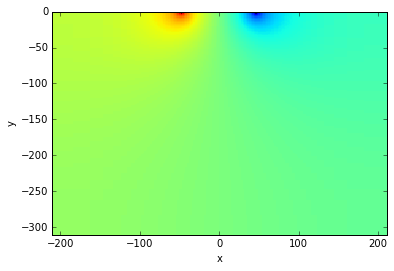

In [9]:
mesh.plotImage(phi)
plt.show()

In [10]:
x = mesh.gridCC[0:mesh.vnC[0],0]
P = mesh.getInterpolationMat(Utils.ndgrid(x,np.r_[-1.]),'CC')
phiplt = P*phi

(-100.0, 100.0)

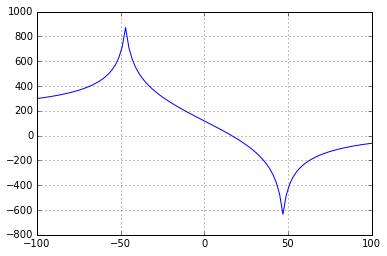

In [11]:
fig, ax = plt.subplots(1,1)
ax.plot(x,phiplt)
ax.grid(which='both')
ax.set_xlim([-100.,100.])

In [32]:
mesh.gridCC[0:mesh.vnC[0],0]

array([-197.02484375, -172.63449519, -153.87268861, -139.4405297 ,
       -128.338869  , -119.79913   , -113.2301    , -108.177     ,
       -104.29      , -101.3       ,  -99.        ,  -97.        ,
        -95.        ,  -93.        ,  -91.        ,  -89.        ,
        -87.        ,  -85.        ,  -83.        ,  -81.        ,
        -79.        ,  -77.        ,  -75.        ,  -73.        ,
        -71.        ,  -69.        ,  -67.        ,  -65.        ,
        -63.        ,  -61.        ,  -59.        ,  -57.        ,
        -55.        ,  -53.        ,  -51.        ,  -49.        ,
        -47.        ,  -45.        ,  -43.        ,  -41.        ,
        -39.        ,  -37.        ,  -35.        ,  -33.        ,
        -31.        ,  -29.        ,  -27.        ,  -25.        ,
        -23.        ,  -21.        ,  -19.        ,  -17.        ,
        -15.        ,  -13.        ,  -11.        ,   -9.        ,
         -7.        ,   -5.        ,   -3.        ,   -1.     